# IMPORTING LIBRARIES

In [2]:
!pip install pytorch-nlp

     |████████████████████████████████| 90 kB 3.1 MB/s 


In [3]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
     |████████████████████████████████| 636 kB 30.1 MB/s 
     |████████████████████████████████| 3.3 MB 32.1 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy
import string
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from scipy.sparse import hstack, csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from torchnlp.encoders.text import StaticTokenizerEncoder, stack_and_pad_tensors, pad_tensor
import torch
import torch.nn as nn

from transformers import BertModel
from transformers import BertTokenizerFast
from tqdm import notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight

# 1. PROBLEM STATEMENT

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone or neutral. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds.

# 2. LOADING DATASET

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dir = "drive/MyDrive/AV/"

In [7]:
df = pd.read_csv(dir + 'Tweets.csv')

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# 3. EDA

In [ ]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [ ]:
df.shape

(14640, 15)

#### CLASS COUNTS

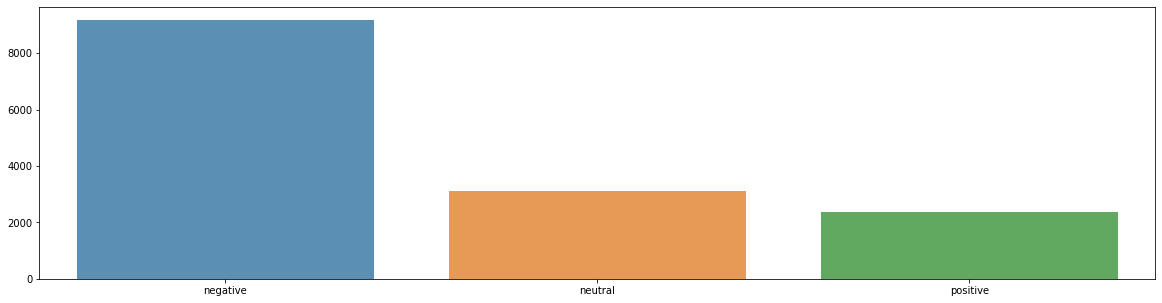

In [ ]:
count = df.airline_sentiment.value_counts()
plt.figure(figsize=(20,5))
sns.barplot(count.index, count.values, alpha=0.8)
plt.xticks()
plt.show()

#### CLEANING TEXT

In [8]:
nlp = English()

In [9]:
def clean_text(text):
    cleaned = text.lower()
    
    punctuations = string.punctuation
    cleaned = "".join(character for character in cleaned if character not in punctuations)
    
    my_doc = nlp(cleaned)
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    
    filtered_sentence =[] 
    
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    
    cleaned = filtered_sentence[1:]
    cleaned = " ".join(cleaned)
    
    return cleaned

In [10]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

#### WORD CLOUD

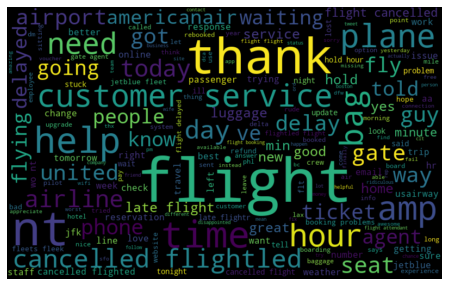

In [ ]:
all_words = ' '.join([text for text in df['cleaned_text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### SENTENCE LENGTHS

Text(0.5, 1.0, 'Histogram: Length of sentences')

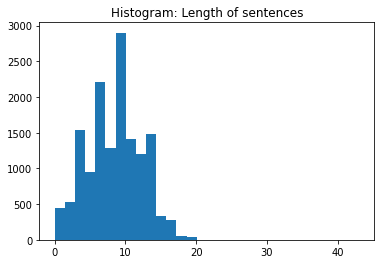

In [ ]:
# compute no. of words in each tweet
num = [len(i.split()) for i in df['cleaned_text']]
plt.hist(num, bins = 30)
plt.title("Histogram: Length of sentences")

# 4. FEATURE ENGINEERING

#### GATHERING RELEVANT DATA

In [18]:
new_df = df[['text', 'cleaned_text', 'airline_sentiment']]

In [ ]:
new_df.head()

,text,cleaned_text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,dhepburn said,neutral
1,@VirginAmerica plus you've added commercials t...,plus ve added commercials experience tacky,positive
2,@VirginAmerica I didn't today... Must mean I n...,nt today mean need trip,neutral
3,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,negative
4,@VirginAmerica and it's a really big bad thing...,big bad thing,negative


### CREATING META FEATURES

In [ ]:
# NUMBER OF WORDS IN ORIGINAL TEXT
new_df["word_count"] = new_df["text"].apply(lambda x : len(x.split()))

In [ ]:
# NUMBER OF WORDS IN CLEANED TEXT
new_df["word_count_cleand"] = new_df["cleaned_text"].apply(lambda x : len(x.split()))

In [ ]:
# NUMBER OF CHARACTERS INCLUDING SPACES IN THE CLEANED TEXT
new_df["char_count"] = new_df["cleaned_text"].apply(lambda x : len(x))

In [ ]:
# NUMBER OF CHARACTERS EXCLUDING SPACES IN THE CLEANED TEXT
new_df["char_count_without_spaces"] = new_df["cleaned_text"].apply(lambda x : len(x.replace(" ","")))

In [ ]:
# NUMBER OF DIGITS IN THE CLEANED TEXT
new_df["num_dig"] = new_df["cleaned_text"].apply(lambda x :  sum([1 if w.isdigit() else 0 for w in x.split()]))

In [ ]:
new_df

,text,cleaned_text,airline_sentiment,word_count,word_count_cleand,char_count,char_count_without_spaces,num_dig
0,@VirginAmerica What @dhepburn said.,dhepburn said,neutral,4,2,13,12,0
1,@VirginAmerica plus you've added commercials t...,plus ve added commercials experience tacky,positive,9,6,42,37,0
2,@VirginAmerica I didn't today... Must mean I n...,nt today mean need trip,neutral,12,5,23,19,0
3,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,negative,17,9,73,65,0
4,@VirginAmerica and it's a really big bad thing...,big bad thing,negative,10,3,13,11,0
...,...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,thank got different flight chicago,positive,11,5,34,30,0
14636,@AmericanAir leaving over 20 minutes Late Flig...,leaving 20 minutes late flight warnings commun...,negative,23,16,105,90,2
14637,@AmericanAir Please bring American Airlines to...,bring american airlines blackberry10,neutral,7,4,36,33,0
14638,"@AmericanAir you have my money, you change my ...",money change flight nt answer phones suggestio...,negative,23,8,59,52,0


### COUNTING NOUNS AND VERBS

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Dictionary of noun and verb POS tags
pos_dic = {"noun" : ["NNP", "NN", "NNS", "NNPS"], "verb" : ["VBZ", "VB", "VBD","VBG", "VBN"]}

In [ ]:
def pos_check(txt, family):

    txt = nlp(txt)
    
    all_tags = []

    for w in txt:
        all_tags.append(w.tag_)
    
    count = 0

    for tag in all_tags:
        if tag in pos_dic[family]:
            count += 1

    return count

In [ ]:
new_df["noun_count"] = new_df["cleaned_text"].apply(lambda x : pos_check(x, "noun"))
new_df["verb_count"] = new_df["cleaned_text"].apply(lambda x : pos_check(x, "verb"))

In [ ]:
vec_bow = CountVectorizer(ngram_range=(1, 3), min_df=400)
vec_bow.fit(new_df['cleaned_text'])
bow1 = vec_bow.transform(new_df['cleaned_text'])

In [ ]:
vec1 = CountVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_bow = FeatureUnion([("char", vec1), ("word", vec2)])
vec_bow.fit(new_df['cleaned_text'])
bow2 = vec_bow.transform(new_df['cleaned_text'])

In [ ]:
vec1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_tfidf = FeatureUnion([("char", vec1), ("word", vec2)])
vec_tfidf.fit(new_df['cleaned_text'])
tfidf1 = vec_tfidf.transform(new_df['cleaned_text'])

In [ ]:
feature_set1 = new_df[['word_count','word_count_cleand','char_count','char_count_without_spaces','num_dig','noun_count','verb_count']]
feature_set1 = hstack([tfidf1, csr_matrix(feature_set1)], "csr")

#### LABEL ENCODING

In [19]:
le = LabelEncoder()
labels = le.fit_transform(new_df['airline_sentiment'])

In [ ]:
labels[:10]

array([1, 2, 1, 0, 0, 0, 2, 1, 2, 2])

In [ ]:
le.inverse_transform([0,1,2])

array(['negative', 'neutral', 'positive'], dtype=object)

# 5. MODEL SELECTION

In [ ]:
def cv_score(ml_model, DATA):
    i = 1
    cv_scores = []
    
    kf = StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
    for train_index, test_index in kf.split(DATA, labels):
        xtr,xvl = DATA[train_index], DATA[test_index]
        ytr,yvl = labels[train_index], labels[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        pred_tr = model.predict_proba(xtr)
        pred_vl = model.predict_proba(xvl)
        
        pred_tr = np.argmax(pred_tr, axis=1)
        pred_vl = np.argmax(pred_vl, axis=1)
        
        f1_tr = f1_score(ytr, pred_tr, average="weighted")
        f1_vl = f1_score(yvl, pred_vl, average="weighted")
        print('\n{} of kfold {}'.format(i, kf.n_splits))
        msg = "Train F1: {:.5f} ".format(f1_tr)
        msg += "Valid F1: {:.5f} ".format(f1_vl)
        print("{}".format(msg))
        
        i+=1

### LOGISTIC REGRESSION

In [ ]:
cv_score(LogisticRegression(C=0.1,class_weight="balanced"), bow1)


1 of kfold 5
Train F1: 0.61744 Valid F1: 0.59887 

2 of kfold 5
Train F1: 0.60907 Valid F1: 0.60646 

3 of kfold 5
Train F1: 0.60422 Valid F1: 0.62094 

4 of kfold 5
Train F1: 0.60427 Valid F1: 0.59900 

5 of kfold 5
Train F1: 0.60202 Valid F1: 0.60946 


In [ ]:
cv_score(LogisticRegression(C=0.1,class_weight="balanced"), bow2)


1 of kfold 5
Train F1: 0.75234 Valid F1: 0.70014 

2 of kfold 5
Train F1: 0.75321 Valid F1: 0.70683 

3 of kfold 5
Train F1: 0.74881 Valid F1: 0.70927 

4 of kfold 5
Train F1: 0.75366 Valid F1: 0.69559 

5 of kfold 5
Train F1: 0.75067 Valid F1: 0.71067 


In [ ]:
cv_score(LogisticRegression(C=0.1,class_weight="balanced"), tfidf1)


1 of kfold 5
Train F1: 0.71644 Valid F1: 0.69497 

2 of kfold 5
Train F1: 0.71213 Valid F1: 0.69976 

3 of kfold 5
Train F1: 0.71263 Valid F1: 0.70482 

4 of kfold 5
Train F1: 0.71198 Valid F1: 0.69539 

5 of kfold 5
Train F1: 0.71410 Valid F1: 0.70622 


In [ ]:
cv_score(LogisticRegression(C=0.1,class_weight="balanced"), feature_set1)


1 of kfold 5
Train F1: 0.65596 Valid F1: 0.64038 

2 of kfold 5
Train F1: 0.64478 Valid F1: 0.66072 

3 of kfold 5
Train F1: 0.64886 Valid F1: 0.65577 

4 of kfold 5
Train F1: 0.65547 Valid F1: 0.64699 

5 of kfold 5
Train F1: 0.65490 Valid F1: 0.65425 


### NAIVE BAYERS

In [ ]:
cv_score(MultinomialNB(alpha=.01), bow1)


1 of kfold 5
Train F1: 0.59058 Valid F1: 0.59059 

2 of kfold 5
Train F1: 0.58915 Valid F1: 0.59601 

3 of kfold 5
Train F1: 0.59067 Valid F1: 0.58876 

4 of kfold 5
Train F1: 0.59756 Valid F1: 0.59070 

5 of kfold 5
Train F1: 0.59080 Valid F1: 0.58868 


In [ ]:
cv_score(MultinomialNB(alpha=.01), bow2)


1 of kfold 5
Train F1: 0.65815 Valid F1: 0.63955 

2 of kfold 5
Train F1: 0.65241 Valid F1: 0.65708 

3 of kfold 5
Train F1: 0.65376 Valid F1: 0.64966 

4 of kfold 5
Train F1: 0.65491 Valid F1: 0.63772 

5 of kfold 5
Train F1: 0.64649 Valid F1: 0.64749 


In [ ]:
cv_score(MultinomialNB(alpha=.01), tfidf1)


1 of kfold 5
Train F1: 0.68338 Valid F1: 0.67362 

2 of kfold 5
Train F1: 0.68329 Valid F1: 0.67969 

3 of kfold 5
Train F1: 0.68022 Valid F1: 0.68162 

4 of kfold 5
Train F1: 0.68210 Valid F1: 0.67025 

5 of kfold 5
Train F1: 0.67959 Valid F1: 0.68769 


In [ ]:
cv_score(MultinomialNB(alpha=.01), feature_set1)


1 of kfold 5
Train F1: 0.68959 Valid F1: 0.68291 

2 of kfold 5
Train F1: 0.69023 Valid F1: 0.69320 

3 of kfold 5
Train F1: 0.69040 Valid F1: 0.68246 

4 of kfold 5
Train F1: 0.69036 Valid F1: 0.67738 

5 of kfold 5
Train F1: 0.68771 Valid F1: 0.69161 


### DECISION TREE

In [ ]:
cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), bow1)


1 of kfold 5
Train F1: 0.59388 Valid F1: 0.59043 

2 of kfold 5
Train F1: 0.59338 Valid F1: 0.59467 

3 of kfold 5
Train F1: 0.59627 Valid F1: 0.60117 

4 of kfold 5
Train F1: 0.59802 Valid F1: 0.58948 

5 of kfold 5
Train F1: 0.59783 Valid F1: 0.59284 


In [ ]:
cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), bow2)


1 of kfold 5
Train F1: 0.73280 Valid F1: 0.64135 

2 of kfold 5
Train F1: 0.72772 Valid F1: 0.65962 

3 of kfold 5
Train F1: 0.72590 Valid F1: 0.65884 

4 of kfold 5
Train F1: 0.72280 Valid F1: 0.66381 

5 of kfold 5
Train F1: 0.73189 Valid F1: 0.67273 


In [ ]:
cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), tfidf1)


1 of kfold 5
Train F1: 0.74915 Valid F1: 0.64370 

2 of kfold 5
Train F1: 0.74662 Valid F1: 0.66460 

3 of kfold 5
Train F1: 0.74329 Valid F1: 0.67087 

4 of kfold 5
Train F1: 0.74345 Valid F1: 0.66849 

5 of kfold 5
Train F1: 0.74112 Valid F1: 0.65656 


In [ ]:
cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), feature_set1)


1 of kfold 5
Train F1: 0.74921 Valid F1: 0.64563 

2 of kfold 5
Train F1: 0.74781 Valid F1: 0.67166 

3 of kfold 5
Train F1: 0.74306 Valid F1: 0.66943 

4 of kfold 5
Train F1: 0.74630 Valid F1: 0.65496 

5 of kfold 5
Train F1: 0.74816 Valid F1: 0.65539 


### RANDOM FOREST

In [ ]:
rf_params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 50, 'n_jobs': -1}

In [ ]:
cv_score(RandomForestClassifier(**rf_params), bow1)


1 of kfold 5
Train F1: 0.62156 Valid F1: 0.58569 

2 of kfold 5
Train F1: 0.62345 Valid F1: 0.59233 

3 of kfold 5
Train F1: 0.62148 Valid F1: 0.59737 

4 of kfold 5
Train F1: 0.62527 Valid F1: 0.58729 

5 of kfold 5
Train F1: 0.62234 Valid F1: 0.59189 


In [ ]:
cv_score(RandomForestClassifier(**rf_params), bow2)


1 of kfold 5
Train F1: 0.99403 Valid F1: 0.70212 

2 of kfold 5
Train F1: 0.99480 Valid F1: 0.71111 

3 of kfold 5
Train F1: 0.99514 Valid F1: 0.71194 

4 of kfold 5
Train F1: 0.99480 Valid F1: 0.70928 

5 of kfold 5
Train F1: 0.99497 Valid F1: 0.70697 


In [ ]:
cv_score(RandomForestClassifier(**rf_params), tfidf1)


1 of kfold 5
Train F1: 0.99386 Valid F1: 0.69805 

2 of kfold 5
Train F1: 0.99488 Valid F1: 0.70528 

3 of kfold 5
Train F1: 0.99531 Valid F1: 0.70833 

4 of kfold 5
Train F1: 0.99488 Valid F1: 0.71154 

5 of kfold 5
Train F1: 0.99505 Valid F1: 0.70579 


In [ ]:
cv_score(RandomForestClassifier(**rf_params), feature_set1)


1 of kfold 5
Train F1: 0.99505 Valid F1: 0.69241 

2 of kfold 5
Train F1: 0.99573 Valid F1: 0.71119 

3 of kfold 5
Train F1: 0.99556 Valid F1: 0.70160 

4 of kfold 5
Train F1: 0.99582 Valid F1: 0.70916 

5 of kfold 5
Train F1: 0.99582 Valid F1: 0.70752 


## NN DATA

In [20]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

In [21]:
sent_id = []

for i in notebook.tqdm(range(len(df['cleaned_text']))):
    encoded_sent = tokenizer.encode(df['cleaned_text'][i], add_special_tokens = False, max_length = 30, truncation = True, pad_to_max_length='right')    
    sent_id.append(encoded_sent)

  0%|          | 0/14640 [00:00<?, ?it/s]

In [22]:
attention_masks = []

for sent in sent_id:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [23]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id, labels, random_state = 2021, test_size = 0.1, stratify = labels)

In [24]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 2021, test_size = 0.1, stratify = labels)

In [25]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [26]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = len(train_inputs))

In [27]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

validation_sampler = SequentialSampler(validation_data)

validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = len(validation_inputs))

In [21]:
class RNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, num_layers=2, dropout=0.3):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*30,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2,3)
        self.relu =  nn.ReLU()
    def forward(self, input_sequence, model_type):
        embedded = self.embedding(input_sequence)
        if model_type == "RNN":
          outputs, hidden = self.rnn(embedded)
        elif model_type == "GRU":
          outputs, hidden = self.gru(embedded)
        elif model_type == "LSTM":
          outputs, (hidden, cell) = self.lstm(embedded)
        x = self.fc1(outputs.contiguous().view(-1, 30 * self.hidden_size))
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [19]:
class_weights = compute_class_weight('balanced', np.unique(labels), labels)

In [20]:
weights = torch.tensor(class_weights, dtype = torch.float)

In [21]:
criterion = nn.CrossEntropyLoss(weights)

In [25]:
def train(model, dataloader, model_type):
    model.train()
    all_preds = []
    all_labels = []
    for step, batch in enumerate(dataloader):
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, model_type)
        loss =  criterion(preds, labels.long())
        loss.backward()
        optimizer.step()
        all_preds.extend(np.argmax(nn.LogSoftmax(dim=1)(preds).detach().cpu().numpy(), axis=1))
        all_labels.extend(labels.detach().cpu().numpy())
    return f1_score(all_labels, all_preds, average="weighted")

In [26]:
def valid(model, dataloader, model_type):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for step, batch in enumerate(dataloader):     
            sent_id, mask, labels = batch
            preds = model(sent_id, model_type)
            all_preds.extend(np.argmax(nn.LogSoftmax(dim=1)(preds).detach().cpu().numpy(), axis=1))
            all_labels.extend(labels.detach().cpu().numpy())
    return f1_score(all_labels, all_preds, average="weighted")

### RNN

In [457]:
model_RNN = RNN(128, 200, 1, 0.3)

In [448]:
optimizer = torch.optim.Adam(model_RNN.parameters(), lr = 0.002)

In [464]:
epoches = 30
best_f1_score = 0
for i in range(epoches):
    f1_train = train(model_RNN, train_dataloader, "RNN")
    f1_valid = valid(model_RNN, validation_dataloader, "RNN")
    print('EPOCH {:} / {:}...TRAIN F1 {}...TEST F1 {}'.format(i+1, epoches, f1_train, f1_valid))
    if f1_valid > best_f1_score:
      print('.....^^SAVING BEST MODEL^^.....')
      torch.save(model_RNN.state_dict(), dir + 'saved_rnn_weights.pt')
      best_f1_score = f1_valid

EPOCH 1 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
.....^^SAVING BEST MODEL^^.....
EPOCH 2 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 3 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 4 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 5 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 6 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 7 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 8 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 9 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 10 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 11 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 12 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EPOCH 13 / 30...TRAIN F1 0.07633284973997262...TEST F1 0.08475873842636805
EP

### GRU

In [465]:
model_GRU = RNN(256, 200, 1, 0.3)

In [466]:
optimizer = torch.optim.Adam(model_GRU.parameters(), lr = 0.002)

In [467]:
epoches = 30
best_f1_score = 0
for i in range(epoches):
    f1_train = train(model_GRU, train_dataloader, "GRU")
    f1_valid = valid(model_GRU, validation_dataloader, "GRU")
    print('EPOCH {:} / {:}...TRAIN F1 {}...TEST F1 {}'.format(i+1, epoches, f1_train, f1_valid))
    if f1_valid > best_f1_score:
      print('.....^^SAVING BEST MODEL^^.....')
      torch.save(model_GRU.state_dict(), dir + 'saved_gru_weights.pt')
      best_f1_score = f1_valid

EPOCH 1 / 30...TRAIN F1 0.04487503611028089...TEST F1 0.5372546808623705
.....^^SAVING BEST MODEL^^.....
EPOCH 2 / 30...TRAIN F1 0.5548419653171205...TEST F1 0.053632560088456
EPOCH 3 / 30...TRAIN F1 0.05942005799471486...TEST F1 0.07971057824176112
EPOCH 4 / 30...TRAIN F1 0.07791123181792009...TEST F1 0.5005826635888988
EPOCH 5 / 30...TRAIN F1 0.5033183839920462...TEST F1 0.5495760269637724
.....^^SAVING BEST MODEL^^.....
EPOCH 6 / 30...TRAIN F1 0.5727104760947443...TEST F1 0.4387754501223275
EPOCH 7 / 30...TRAIN F1 0.48030707979090437...TEST F1 0.5816475532035718
.....^^SAVING BEST MODEL^^.....
EPOCH 8 / 30...TRAIN F1 0.6146079796474816...TEST F1 0.6143534944525197
.....^^SAVING BEST MODEL^^.....
EPOCH 9 / 30...TRAIN F1 0.6260214847827474...TEST F1 0.5994044067908422
EPOCH 10 / 30...TRAIN F1 0.6294465611844747...TEST F1 0.618027508804855
.....^^SAVING BEST MODEL^^.....
EPOCH 11 / 30...TRAIN F1 0.6442604794929379...TEST F1 0.6170342381057317
EPOCH 12 / 30...TRAIN F1 0.6573332908703797

### LSTM

In [468]:
model_LSTM = RNN(128, 200, 1, 0.3)#.cuda()

In [469]:
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr = 0.002)

In [470]:
epoches = 30
best_f1_score = 0
for i in range(epoches):
    f1_train = train(model_LSTM, train_dataloader, "LSTM")
    f1_valid = valid(model_LSTM, validation_dataloader, "LSTM")
    print('EPOCH {:} / {:}...TRAIN F1 {}...TEST F1 {}'.format(i+1, epoches, f1_train, f1_valid))
    if f1_valid > best_f1_score:
      print('.....^^SAVING BEST MODEL^^.....')
      torch.save(model_LSTM.state_dict(), dir + 'saved_lstm_weights.pt')
      best_f1_score = f1_valid

EPOCH 1 / 30...TRAIN F1 0.49710664449329056...TEST F1 0.08568704433960736
.....^^SAVING BEST MODEL^^.....
EPOCH 2 / 30...TRAIN F1 0.0808997295147212...TEST F1 0.49483275942425636
.....^^SAVING BEST MODEL^^.....
EPOCH 3 / 30...TRAIN F1 0.5035629442972674...TEST F1 0.5059332842514321
.....^^SAVING BEST MODEL^^.....
EPOCH 4 / 30...TRAIN F1 0.5243554499663408...TEST F1 0.4068430289569271
EPOCH 5 / 30...TRAIN F1 0.4301187156353918...TEST F1 0.5374645366188283
.....^^SAVING BEST MODEL^^.....
EPOCH 6 / 30...TRAIN F1 0.5613544371214513...TEST F1 0.5864945470128078
.....^^SAVING BEST MODEL^^.....
EPOCH 7 / 30...TRAIN F1 0.6056930665982826...TEST F1 0.5632220280336147
EPOCH 8 / 30...TRAIN F1 0.5924761119136864...TEST F1 0.5828232573652571
EPOCH 9 / 30...TRAIN F1 0.6248044003314513...TEST F1 0.5919812863742105
.....^^SAVING BEST MODEL^^.....
EPOCH 10 / 30...TRAIN F1 0.6350592987660775...TEST F1 0.6092644411302026
.....^^SAVING BEST MODEL^^.....
EPOCH 11 / 30...TRAIN F1 0.6494507066589494...TEST F

### CONVOLUTIONAL

In [588]:
class CONV(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super(CONV, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_size)
        self.cnn1 = nn.Conv1d(in_channels=embedding_size, out_channels=hidden_size, kernel_size=3, stride=1 )
        self.cnn2 = nn.Conv1d(hidden_size, hidden_size//2, 3, stride=1)
        self.cnn3 = nn.Conv1d(hidden_size//2, hidden_size//4, 3, stride=1)
        self.fc1 = nn.Linear(hidden_size//4 * (30-3*(2)),hidden_size*4)
        self.fc2 = nn.Linear(hidden_size*4,hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2,3)
        self.relu =  nn.ReLU()
    def forward(self, input_sequence, zzz):
        embedded = self.embedding(input_sequence)
        shape = embedded.shape
        embedded = embedded.reshape(shape[0],shape[2],shape[1])
        x = self.cnn1(embedded)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [595]:
model_CONV = CONV(128, 64)#.cuda()

In [596]:
optimizer = torch.optim.Adam(model_CONV.parameters(), lr = 0.002)

In [597]:
epoches = 30
best_f1_score = 0
for i in range(epoches):
    f1_train = train(model_CONV, train_dataloader, "CONV")
    f1_valid = valid(model_CONV, validation_dataloader, "CONV")
    print('EPOCH {:} / {:}...TRAIN F1 {}...TEST F1 {}'.format(i+1, epoches, f1_train, f1_valid))
    if f1_valid > best_f1_score:
      print('.....^^SAVING BEST MODEL^^.....')
      torch.save(model_CONV.state_dict(), dir + 'saved_conv_weights.pt')
      best_f1_score = f1_valid

EPOCH 1 / 30...TRAIN F1 0.48319011621657404...TEST F1 0.3554240990428477
.....^^SAVING BEST MODEL^^.....
EPOCH 2 / 30...TRAIN F1 0.3805781670826163...TEST F1 0.547468279896766
.....^^SAVING BEST MODEL^^.....
EPOCH 3 / 30...TRAIN F1 0.5604358960558325...TEST F1 0.4025303703796928
EPOCH 4 / 30...TRAIN F1 0.4278017223034436...TEST F1 0.5457554604401671
EPOCH 5 / 30...TRAIN F1 0.5462381547146099...TEST F1 0.5105756465934769
EPOCH 6 / 30...TRAIN F1 0.5312387980106713...TEST F1 0.4900196819928927
EPOCH 7 / 30...TRAIN F1 0.5185271241924955...TEST F1 0.5553991588847658
.....^^SAVING BEST MODEL^^.....
EPOCH 8 / 30...TRAIN F1 0.5855137827801263...TEST F1 0.5759492148971194
.....^^SAVING BEST MODEL^^.....
EPOCH 9 / 30...TRAIN F1 0.606564871664081...TEST F1 0.5551300222242154
EPOCH 10 / 30...TRAIN F1 0.5919241398707229...TEST F1 0.5299083298887095
EPOCH 11 / 30...TRAIN F1 0.5858351128890475...TEST F1 0.5405131457624444
EPOCH 12 / 30...TRAIN F1 0.5759179393494257...TEST F1 0.47089727676216964
EPOCH

### BERT

In [28]:
train_dataloader_bert = DataLoader(train_data, sampler = train_sampler, batch_size = 32)

In [29]:
validation_dataloader_bert = DataLoader(validation_data, sampler = validation_sampler, batch_size = 32)

In [30]:
bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
for param in bert.parameters():
    param.requires_grad = False

In [32]:
class BERT(nn.Module):
    def __init__(self, bert, hidden):
        super(BERT, self).__init__()
        self.bert = bert
        self.hidden = hidden
        self.fc1 = nn.Linear(768,hidden)
        self.fc2 = nn.Linear(hidden,3)
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()

    def forward(self, sent_id, mask):
        out = self.bert(sent_id, attention_mask = mask)
        all_hidden_states, cls_hidden_state = out[0], out[1]
        x = self.fc1(cls_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
model_BERT = BERT(bert, 512).cuda()

In [34]:
optimizer = torch.optim.Adam(model_BERT.parameters(), lr = 0.001)

In [35]:
class_weights = compute_class_weight('balanced', np.unique(labels), labels)

In [36]:
weights = torch.tensor(class_weights, dtype = torch.float).cuda()

In [37]:
criterion = nn.CrossEntropyLoss(weights)

In [38]:
def train(model, dataloader):
    model.train()
    all_preds = []
    all_labels = []
    for step, batch in enumerate(dataloader):
        batch = tuple(t.cuda() for t in batch)
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss =  criterion(preds, labels.long())
        loss.backward()
        optimizer.step()
        all_preds.extend(np.argmax(nn.LogSoftmax(dim=1)(preds).detach().cpu().numpy(), axis=1))
        all_labels.extend(labels.detach().cpu().numpy())
    return f1_score(all_labels, all_preds, average="weighted")

In [41]:
def valid(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for step, batch in enumerate(dataloader):
            batch = tuple(t.cuda() for t in batch)     
            sent_id, mask, labels = batch
            preds = model(sent_id, mask)
            all_preds.extend(np.argmax(nn.LogSoftmax(dim=1)(preds).detach().cpu().numpy(), axis=1))
            all_labels.extend(labels.detach().cpu().numpy())
    return f1_score(all_labels, all_preds, average="weighted")

In [42]:
epoches = 30
best_f1_score = 0
for i in range(epoches):
    f1_train = train(model_BERT, train_dataloader_bert)
    f1_valid = valid(model_BERT, validation_dataloader_bert)
    print('EPOCH {:} / {:}...TRAIN F1 {}...TEST F1 {}'.format(i+1, epoches, f1_train, f1_valid))
    if f1_valid > best_f1_score:
      print('.....^^SAVING BEST MODEL^^.....')
      torch.save(model_BERT.state_dict(), dir + 'saved_bert_weights.pt')
      best_f1_score = f1_valid

EPOCH 1 / 30...TRAIN F1 0.5032106606648674...TEST F1 0.41685742191331626
.....^^SAVING BEST MODEL^^.....
EPOCH 2 / 30...TRAIN F1 0.5183175137842556...TEST F1 0.5485251587943344
.....^^SAVING BEST MODEL^^.....
EPOCH 3 / 30...TRAIN F1 0.5327613735420417...TEST F1 0.5420750104115176
EPOCH 4 / 30...TRAIN F1 0.5324815432144195...TEST F1 0.5695012719033599
.....^^SAVING BEST MODEL^^.....
EPOCH 5 / 30...TRAIN F1 0.5527214071344345...TEST F1 0.6050186631455082
.....^^SAVING BEST MODEL^^.....
EPOCH 6 / 30...TRAIN F1 0.5413211715016687...TEST F1 0.5358699422451434
EPOCH 7 / 30...TRAIN F1 0.5459375596017393...TEST F1 0.5955975214994408
EPOCH 8 / 30...TRAIN F1 0.5499499171434994...TEST F1 0.5746627971339057
EPOCH 9 / 30...TRAIN F1 0.5426512704546331...TEST F1 0.6476025535100289
.....^^SAVING BEST MODEL^^.....
EPOCH 10 / 30...TRAIN F1 0.5559101944549473...TEST F1 0.6454281784774156
EPOCH 11 / 30...TRAIN F1 0.549188920082862...TEST F1 0.6149027724914727
EPOCH 12 / 30...TRAIN F1 0.5451021402258531...

# LSTM MODEL GAVE BEST RESULT